In [336]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import plotly
import plotly.graph_objects as go
import plotly.express as px
import datetime
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')
from torchsummary import summary
import torch
import torchmetrics
from torch.utils.data import DataLoader, Dataset, TensorDataset

---
First, we need to take a bunch of images, resize them to the same size without distorting (so we'll use padding).

In [3]:
#Open image into an 'image' object type
def im_to_vec(file,size=128):
    im_vec = (Image.open(file))
    #calculate height and width
    width, height = (im_vec.size[0]),im_vec.size[1]
    if width > height:
        #calc ratio for resize
        h_c = width/height
        im_vec = im_vec.resize((size,int(size/h_c)))
        #recalculate to get pad values
        width, height = (im_vec.size[0]),im_vec.size[1]
        height_total_pad = width-height
        height_pad_l = int(height_total_pad/2)
        height_pad_r = int((height_total_pad+1)/2)
        im_vec=np.pad(im_vec,pad_width=((height_pad_l,height_pad_r),(0,0),(0,0)))
    elif height > width:
        #resize
        w_c = height/width
        im_vec = im_vec.resize((int(size/w_c),size))
        #pad
        width, height = (im_vec.size[0]),im_vec.size[1]
        width_pad = height-width
        width_pad_l = int(width_pad/2)
        width_pad_r = int((width_pad+1)/2)
        im_vec=np.pad(im_vec,pad_width=((0,0),(width_pad_l,width_pad_r),(0,0)))
    else:
        im_vec = im_vec.resize((size,size))
    
    #Pad it out to a full 128 by 128
    return im_vec

Shape of image is: (128, 128, 3)


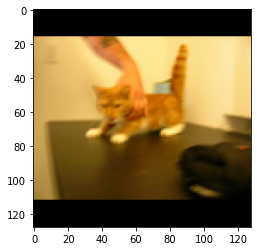

In [4]:
im = '/Users/jacoblourie/Downloads/kagglecatsanddogs_3367a/PetImages/Cat/0.jpg'
im = im_to_vec(im)
print(f'Shape of image is: {im.shape}')
plt.imshow(im)
plt.show()

---
Script to convert all the files

In [5]:
def convert_all_ims_one_array(size, dir_dog, dir_cat,max_im):

    x=np.zeros((25000,size,size,3)).astype(np.uint8)
    dog_length=0
    cat_length=0

    for idx, image in enumerate((os.listdir(dir_dog))[:max_im]):
        try:
            x[idx] = im_to_vec(f'{dir_dog}/{image}',size=size)
            dog_length+=1

        except:
            continue

    for idx, image in enumerate((os.listdir(dir_cat))[:max_im]):
        try:
            x[dog_length+idx] = im_to_vec(f'{dir_cat}/{image}',size=size)
            cat_length+=1

        except:
            continue
            
    y=np.append(np.zeros((dog_length)),np.ones(cat_length))
    x = x[:len(y)]
    print(cat_length)
    return x, y


In [294]:
dir_dogs = '/Users/jacoblourie/Downloads/kagglecatsanddogs_3367a/PetImages/Dog'
dir_cat = '/Users/jacoblourie/Downloads/kagglecatsanddogs_3367a/PetImages/Cat'
size=64
x,y = convert_all_ims_one_array(size, dir_dogs, dir_cat,max_im=10000)

9971


In [295]:
x.shape,len(y)

((19936, 64, 64, 3), 19936)

---
EigenVectors

We are going to reduce the dimensionality of our dataset(currently 128x128) by using eigenvectors. This will allow us to capture the most important variations between images. We will then see if we can apply just this reduced number of dimensions to a neural net and gain a similar performance level to that which we achieved with a ResNet on the full images (~85%)

Steps: 

1- Flatten arrays 

2- normalize data across each dimension

3- Compute N eigenvectors and the covariance matrix


4- Project images onto eigenspace using projection matrix:  

- projection = B @ (B.T@B)^-1 @ B.T } 

where B is new basis. B.T@B will be the identity matrix if the eigenvectors are normalised, so it would just become:

- projection = B @ B.T

We will experiment with various choices of N, but 20 is a good place to start

In [367]:
import tempfile

In [371]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [467]:
x_train_part = x_train[:30000]
y_train_part = y_train[:30000]

(30000,)

In [474]:
x = (x_train_part/255)
x = x.reshape(x.shape[0],-1)
y=y_train_part

In [452]:
#get data into a data object and then create the batches
def create_dataloaders(x,y,batch_size):
    tensor_x = torch.Tensor(x) # transform to torch tensor
    tensor_y = torch.Tensor(y)
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_data, val_data = torch.utils.data.random_split(my_dataset, [int(0.8*len(y)), len(y)-int(0.8*len(y))])
    train_dataloader = DataLoader(train_data,batch_size=batch_size)
    val_dataloader = DataLoader(val_data,batch_size=batch_size) 
    return train_dataloader, val_dataloader


In [503]:
#create sequential model
class seven_layer_model(torch.nn.Module):
    """don't think we need to do super() because we aren't doing a separate init"""
    def __init__(self,inputdim=50):
        super().__init__()
        self.tanh = torch.nn.Tanh()
        self.batch1 = torch.nn.BatchNorm1d(100)
        self.batch2 = torch.nn.BatchNorm1d(100)
        self.batch3 = torch.nn.BatchNorm1d(100)
        self.batch4 = torch.nn.BatchNorm1d(100)

        self.layer1 = torch.nn.Linear(inputdim,100)
        self.layer2 = torch.nn.Linear(100,100)
        self.layer3 = torch.nn.Linear(100,100)
        self.layer4 = torch.nn.Linear(100,100)
        
        self.layer5 = torch.nn.Linear(100,10)        
        self.softmax = torch.nn.Softmax(dim=1)
        for layer in self.parameters():
            if layer == torch.nn.Linear:
                torch.nn.init.xavier_uniform(layer.weight)

    def forward(self,x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.batch1(x)
        x2 = self.layer2(x)
        x2 = self.tanh(x)
        x2 = self.batch2(x)
        x3 = self.batch3(self.tanh(self.layer3(x)))
        x4 = self.batch4(x2 + self.tanh(self.layer4(x)))
        x5 = self.layer5(x4)
        output = self.softmax(x5)
        return output


#create forward pass and backward pass
def train_step(model, dataloader, criterion,optimizer, accuracy_metric, printy=True):
    model.train()
    for x,y in dataloader:
        outputs = model(x)
        y = y.long()
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        predictions = torch.argmax(outputs,axis=-1)
        accuracy_metric(outputs,y)
    acc = accuracy_metric.compute()
    if printy:
        print('Train Accuracy: ', acc)
        

def val_step(model, dataloader,accuracy_metric):
    model.eval()
    with torch.no_grad():
        for x,y in dataloader:
            outputs = model(x)
            y = y.long()
            predictions = torch.argmax(outputs,axis=-1)

            accuracy_metric(outputs,y)
        acc = accuracy_metric.compute()
    print('Val Accuracy: ', acc)
    
def train_model(model,train_dataloader,val_dataloader, criterion, optimizer, accuracy_metric, epochs):
    for epoch in range(epochs):
        
        if epoch+1 in np.geomspace(2,64,6):
            print(f'epoch: {epoch+1}')
            train_step(model,train_dataloader, criterion, optimizer, accuracy_metric)
            val_step(model, val_dataloader,accuracy_metric)
        else:
            train_step(model,train_dataloader,criterion, optimizer, accuracy_metric,printy=False)


In [505]:
train_dataloader, val_dataloader = create_dataloaders(x, y, 200)
#define metrics.
accuracy_metric = torchmetrics.Accuracy()

pre_eig_model = seven_layer_model(inputdim=X.shape[1])

#create optimizer - which includes the model as a parameter
optimizer = torch.optim.Adam(pre_eig_model.parameters())

#create criterion
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_model(pre_eig_model, train_dataloader, val_dataloader, criterion, optimizer, accuracy_metric, epochs=65)

epoch: 2
Train Accuracy:  tensor(0.8894)
Val Accuracy:  tensor(0.8933)


----
Small comparison to sequential

In [ ]:
seq_model = torch.nn.Sequential(torch.nn.Linear(X.shape[1],100),torch.nn.ReLU(),
                               torch.nn.Linear(100,100),torch.nn.ReLU(),
                               torch.nn.Linear(100,200),torch.nn.ReLU(),
                               torch.nn.Linear(200,160),torch.nn.ReLU(),
                               torch.nn.Linear(160,10), torch.nn.Softmax())
criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')  ### calcualte the loss
seq_optimizer = torch.optim.SGD(seq_model.parameters(),lr=0.1,momentum=0.9)
train_model(seq_model, train_dataloader, val_dataloader, criterion, seq_optimizer, accuracy_metric, epochs=17)

In [485]:
for param in seq_model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0148,  0.0286, -0.0354,  ...,  0.0055, -0.0016, -0.0069],
        [-0.0148, -0.0339,  0.0246,  ...,  0.0291, -0.0047, -0.0225],
        [-0.0008, -0.0043,  0.0073,  ..., -0.0206,  0.0257, -0.0325],
        ...,
        [ 0.0301, -0.0236, -0.0143,  ..., -0.0078, -0.0304,  0.0297],
        [-0.0088,  0.0007,  0.0277,  ...,  0.0221, -0.0084,  0.0250],
        [ 0.0107, -0.0072,  0.0352,  ..., -0.0149,  0.0059, -0.0237]],
       requires_grad=True)
Parameter containing:
tensor([-2.5340e-02, -3.3443e-02, -8.2685e-02,  3.8922e-04,  4.1391e-02,
         4.5019e-02, -4.8996e-01,  3.9256e-02, -7.7084e-02, -4.2036e-02,
        -2.2188e-01, -5.9288e-02,  8.8133e-02, -1.7738e-02, -2.4909e-02,
        -8.2780e-03, -2.4010e-02,  3.7506e-03, -2.9247e-01, -4.2207e-01,
        -1.1921e-02,  3.3930e-03, -4.4414e-03, -3.8143e-02, -2.6154e-02,
        -1.9206e-01, -6.5357e-02, -2.4959e-01, -7.8852e-03, -2.2260e-02,
        -3.4560e-02, -3.4413e-01, -2.4557e-01,  9.3915e-0

In [437]:
summary(seq_model,input_size=(20,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 20, 400]         314,000
              ReLU-2              [-1, 20, 400]               0
            Linear-3              [-1, 20, 400]         160,400
              ReLU-4              [-1, 20, 400]               0
            Linear-5              [-1, 20, 400]         160,400
              ReLU-6              [-1, 20, 400]               0
            Linear-7              [-1, 20, 400]         160,400
              ReLU-8              [-1, 20, 400]               0
            Linear-9              [-1, 20, 400]         160,400
             ReLU-10              [-1, 20, 400]               0
           Linear-11              [-1, 20, 200]          80,200
             ReLU-12              [-1, 20, 200]               0
           Linear-13              [-1, 20, 160]          32,160
             ReLU-14              [-1, 

In [384]:
'''Data Preprocessing'''

#flatten arrays
X = x_train_part.reshape(x_train_part.shape[0],-1)
#normalize the data
mean = np.mean(X,axis=0)
stdev = np.std(X,axis=0)
X = (X-mean)/stdev

In [297]:
#calculate cov_matrix
cov_matrix = np.cov(X,rowvar=False,bias=True)


In [298]:
#calculate eig vals and vecs
eig_val, eig_vec = np.linalg.eig(cov_matrix)


In [299]:
eig_n = 50
prin_eig_vec, prin_eig_val = eig_vec[:,:eig_n], eig_val[:eig_n]

In [300]:
#Showing that eigenvectors are unit length
np.linalg.norm(prin_eig_vec[:,1])

1.0

In [301]:
X.shape, prin_eig_vec.shape

((19936, 12288), (12288, 50))

In [302]:
#project flat X onto new subspace
P = prin_eig_vec @ prin_eig_vec.T

In [303]:
#project onto all prev_dims
projection_prev_dims = (P @ X.T).T
#project in terms of new dims
projection_eig_dims = X @ prin_eig_vec

In [304]:
P.shape

(12288, 12288)

In [305]:
projection_prev_dims.shape, projection_eig_dims.shape

((19936, 12288), (19936, 50))

---
what does a projection 'look' like - turns out like nothing at all really

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


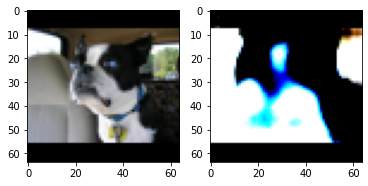

In [306]:
example = 100
fig, axlist = plt.subplots(nrows=1,ncols=2)
axlist[0].imshow(x[example]); 
axlist[1].imshow(5*projection_prev_dims[example].astype(float).reshape(size,size,3)); plt.show()

--- 
The eigenbases also don't look like much - note, we had to remove the complex part of the number to show thme as images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


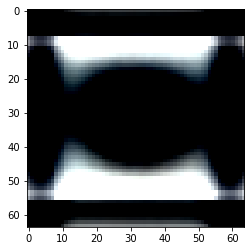

In [307]:
#scaled up eigenvectors
plt.imshow(100*prin_eig_vec[:,5].astype(float).reshape(size,size,3))

----

So can we use this in a dense network to classify cats and dogs

In [356]:
train_model(eigenmodel_50,train_dataloader, val_dataloader, criterion, optimizer, accuracy_metric, epochs=1)

Train Accuracy:  tensor(0.5007)
Val Accuracy:  tensor(0.4998)


---
We dont seem to be getting any joy. Let's try it without eigenvectors

In [343]:
#normalize data
X_norm = X/255
X_norm.shape

(19936, 12288)

In [344]:
train_dataloader_full, val_dataloader_full = create_dataloaders(X_norm,y,20)

In [347]:
#create model and optimizer
normmodel = seven_layer_model(inputdim=X_norm.shape[1])
optimizer_fullfeature = torch.optim.Adam(normmodel.parameters())

In [360]:
#train model
train_model(normmodel, train_dataloader_full, val_dataloader_full, criterion, optimizer_fullfeature, accuracy_metric, epochs =11)

Train Accuracy:  tensor(0.4988)
Val Accuracy:  tensor(0.4998)
Train Accuracy:  tensor(0.4990)
Val Accuracy:  tensor(0.4992)
Train Accuracy:  tensor(0.4990)
Val Accuracy:  tensor(0.4991)


In [361]:
train_model(seq_model, train_dataloader_full, val_dataloader_full, criterion, seq_optimizer, accuracy_metric, epochs = 11)

Train Accuracy:  tensor(0.4991)
Val Accuracy:  tensor(0.4992)
Train Accuracy:  tensor(0.4991)
Val Accuracy:  tensor(0.4992)
Train Accuracy:  tensor(0.4991)
Val Accuracy:  tensor(0.4992)
